 # Using Quantum Computers to Boost Whitebox Fuzzing

## Introduction

In this demonstration we will show how to harness the power of quantum computers for **enhancing software security**. Specifically, We will use the Quantum Grover's algorithm for boosting the process of whitebox fuzzing.

According to [[1](#Whitebox)], the "killer-app" for whitebox fuzzing is the **testing of file\packet parsers**. Any vulnerability of such parser might result with a very costy security patch, so one would want to invest much effort in validating that such code is protected.

### Fuzzing

<center><img src="https://docs.classiq.io/resources/fuzzing.jpeg" width=700/></center>

Fuzzing is a dynamic code testing technique that provides random data, known as "fuzz," to the inputs of a program. The goal is to find bugs, security loopholes, or other unexpected behavior in the software. By feeding the program various input combinations, a fuzzer aims to uncover weaknesses that might be exploited maliciously.

### Whitebox Fuzzing

Whitebox fuzzing, in particular, involves having access to the internal structure and code of the program. It combines static and dynamic analysis to not only execute the program with random inputs but also to achieve maximum code coverage, ensuring that all possible execution paths have been tested. This allows for more targeted and efficient testing. It usually consists of a "symbolic execution" part, in which the program is emulated in order to explore various branches, and gathered into a set of contraints.

The constraints are solved by a constraint solver in order to generate new fuzzing input to the program.

### Toy Example
Let us emphasize the importance of whitebox testing in the following toy example. Take the following function, for which we want to trigger all relevant code flows:

In [1]:
def foo(x: int, y: int):
    if x == 12:
        if y > 3:
            return "a"
        return "b"
    if y + x < 9:
        if (x * y) % 4 == 1:
            return "c"
        return "d"
    return "e"

Now (due to simulation limitations) say that x, y are 6 bit integers, so they are in the range [0, 63].
Let's try to get all the outputs of `foo` in a black-box way, e.g. by sampling random inputs.

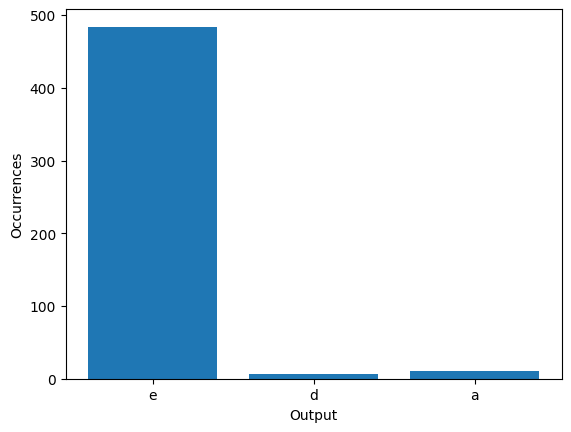

In [2]:
from collections import Counter

import numpy as np
from matplotlib import pyplot as plt

np.random.seed(3)
x_samples = np.random.randint(0, 63, 500)
y_samples = np.random.randint(0, 63, 500)

outputs = [foo(x, y) for x, y in zip(x_samples, y_samples)]


def plot_outputs(outputs):
    char_counts = Counter(outputs)

    # Data for plotting
    chars = ["a", "b", "c", "d", "e"]
    counts = list(char_counts.values())

    # Plotting
    plt.bar(char_counts.keys(), char_counts.values())
    plt.xlabel("Output")
    plt.ylabel("Occurrences")
    plt.show()


plot_outputs(outputs)

We Can see that with 500 inputs, we only reached 3 out of the 5 different outputs for `foo`.

However, by following the flow of `foo`, we can generate the following constraints to the function:
- "a": $ (x = 12) \land (y \gt 3) $
- "b": $ (x = 12) \land (y \leq 3) $
- "c": $ (x + y \lt 9) \land (x \neq 12) \land (x \times y \mod 4 = 1)$
- "d": $ (x + y \lt 9) \land (x \neq 12) \land (x \times y \mod 4 \neq 1)$
- "e": $ (x \neq 12) \land (x + y \lt 9)$

Now, In order to trigger each of the different outputs, we need to find inputs that satisfy the constraints. Some of the constraints might not be satisfiable for any input. Although this toy example is easy, the general case, which is an instance of Constraints Satisfaction Problem (CSP), is computationaly hard and belongs to the $\text{NP-Complete}$ complexity class.

## Here Comes the Quantum Part!

### Grover's Algorithm
The physical nature of quantum computer can be harnessed to generate inputs to the function. Specifically, we can create a 'superposition' of all different inputs - a physical state which holds all the possible assignments to the function inputs, for which we compute whether the constraints is fulfilled. The quantum computer allows only a single classical output of the variable. That where Grover's algorithm [[1](#Gro97),[2](#GroWiki)] takes place - it can generate "good" samples with a high probability, achieving a quadratic(!) speedup over a classical brute-force approach.

### Oracle Function
In the heart of the algorithm, one needs to implement an oracle that compute for each state:

$
O |x\rangle =
\begin{cases}
-|x\rangle & \text{if } f(x) = 1 \\
|x\rangle & \text{otherwise}
\end{cases}
$

Classiq has a built-in Arithmetic engine for computing such oracles. Specifically, lets take the hardest constraint:

* **"c": $ (x + y < 9) \land (x \neq 12) \land (x \times y \mod 4 = 1)$**

We eliminate the $x \neq 12$ as it is already satisfied given the first clause, and create a predicate function for it:

In [3]:
from classiq import *
from classiq.qmod.symbolic import logical_and


@qfunc
def my_predicate(x: QNum, y: QNum, res: QBit) -> None:
    res ^= logical_and((x + y < 9), ((x * y) % 4 == 1))

And we create a phase oracle

In [4]:
@qfunc
def prep_minus(out: Output[QBit]) -> None:
    allocate(1, out)
    X(out)
    H(out)


@qfunc
def my_oracle(predicate: QCallable[QBit]) -> None:
    aux = QBit("aux")
    within_apply(within=lambda: prep_minus(aux), apply=lambda: predicate(aux))

Let's see how a quantum oracle looks like:

In [5]:
REGISTER_SIZE = 6


@qfunc
def main():
    x = QNum("x")
    y = QNum("y")
    allocate(REGISTER_SIZE, False, 0, x)
    allocate(REGISTER_SIZE, False, 0, y)
    my_oracle(predicate=lambda q: my_predicate(x, y, q))


MAX_WIDTH_ORACLE = 25
qmod_oracle = create_model(main)
qmod_oracle = set_constraints(qmod_oracle, max_width=MAX_WIDTH_ORACLE)
qprog_oracle = synthesize(qmod_oracle)
show(qprog_oracle)

Opening: https://platform.classiq.io/circuit/52e3cff0-1eba-43c0-ad58-8fb6477717fd?version=0.41.0.dev39%2B79c8fd0855


<center><img src="https://docs.classiq.io/resources/oracle.jpg" width=700/></center>

### Full Grover's Circuit

Now create the full circuit implementation the Grover's algorithm:

#### State Preparation

Load the uniform superposition state - over all possible input assignments to `foo`, by using the `hadamard_transform`.

In [6]:
@qfunc
def my_sp(x: QNum, y: QNum):
    hadamard_transform(x)
    hadamard_transform(y)

#### Grover Operator

In [7]:
@qfunc
def zero_predicate(x: QNum, y: QNum, res: QBit):
    joined = QNum("joined", x.size + y.size, False, 0)
    bind([x, y], joined)
    control(joined == 0, lambda: X(res))
    bind(joined, [x, y])


@qfunc
def my_diffuser(sp_operand: QCallable[QNum, QNum], x: QNum, y: QNum):

    within_apply(
        lambda: invert(lambda: sp_operand(x, y)),
        lambda: my_oracle(predicate=lambda q: zero_predicate(x, y, q)),
    )


@qfunc
def my_grover_operator(oracle_operand: QCallable, diffuser_operand: QCallable):
    oracle_operand()
    diffuser_operand()

#### Grover Repetitions

The algorithm includes applying a quantum oracle in repetition, such that the probability to sample a good state "rotates" from low to high. Without knowing the concentration of solution before hand (which is the common case), one might overshoot with too many repetitions and not get a solution. Fixed Point Amplitude Amplification (FFPA) ([4](#FFPA)) for example, is a modification to the basic Grover algorithm, which does not suffer from the overshoot issue. However, here for simplicity we will use the basic Grover's Algorithm. We assume that this specific state only satisfied for a specific input, and calculate the number of oracle repetitions required:

In [8]:
GROVER_REPEATS = np.pi / 4 * np.sqrt(2 ** (2 * REGISTER_SIZE) / 2)
GROVER_REPEATS = np.round(GROVER_REPEATS)
print(GROVER_REPEATS)

36.0


This is indeed ~ the square root of the number of possible assignment - $2^{12}$ in this case!

In order to save simulation time, will simplify even further, and use only several grover repetitions, to show that this raises the probability to sample a "c" input.

In [9]:
@qfunc
def main(x: Output[QNum], y: Output[QNum]):
    allocate(REGISTER_SIZE, False, 0, x)
    allocate(REGISTER_SIZE, False, 0, y)
    my_sp(x, y)
    power(
        4,
        lambda: my_grover_operator(
            lambda: my_oracle(predicate=lambda q: my_predicate(x, y, q)),
            lambda: my_diffuser(lambda x, y: my_sp(x, y), x, y),
        ),
    )


qmod_grover = create_model(main)

We will also set constraints for the resulting circuit, so we can simulate it on a quantum simulator:

In [10]:
MAX_WIDTH_GROVER = 25
qmod_grover = set_constraints(qmod_grover, max_width=MAX_WIDTH_GROVER)
write_qmod(qmod_grover, "whitebox_fuzzing")

### Synthesizing the Model

We proceed by synthesizing the circuit using Classiq's synthesis engine. The synthesis takes the should takes the high-level model definition and creates a quantum circuits implementation. It should take approximately several seconds:

In [12]:
qprog_grover = synthesize(qmod_grover)

### Showing the Resulting Circuit

After Classiq's synthesis engine has finished the job, we can show the resulting circuit in the interactive GUI:

In [13]:
show(qprog_grover)

Opening: https://platform.classiq.io/circuit/87e46e1b-0a79-441f-916e-a37c3bdf84e7?version=0.41.0.dev39%2B79c8fd0855


### Executing the circuit

Lastly, we can execute the resulting circuit with Classiq's execute interface, using the `execute` function.

In [14]:
from classiq.execution import (
    ClassiqBackendPreferences,
    ClassiqSimulatorBackendNames,
    ExecutionPreferences,
)

backend_preferences = ExecutionPreferences(
    backend_preferences=ClassiqBackendPreferences(
        backend_name=ClassiqSimulatorBackendNames.SIMULATOR
    ),
    num_shots=500,
)

qprog_grover = set_quantum_program_execution_preferences(
    qprog_grover, backend_preferences
)
result = execute(qprog_grover).result_value()

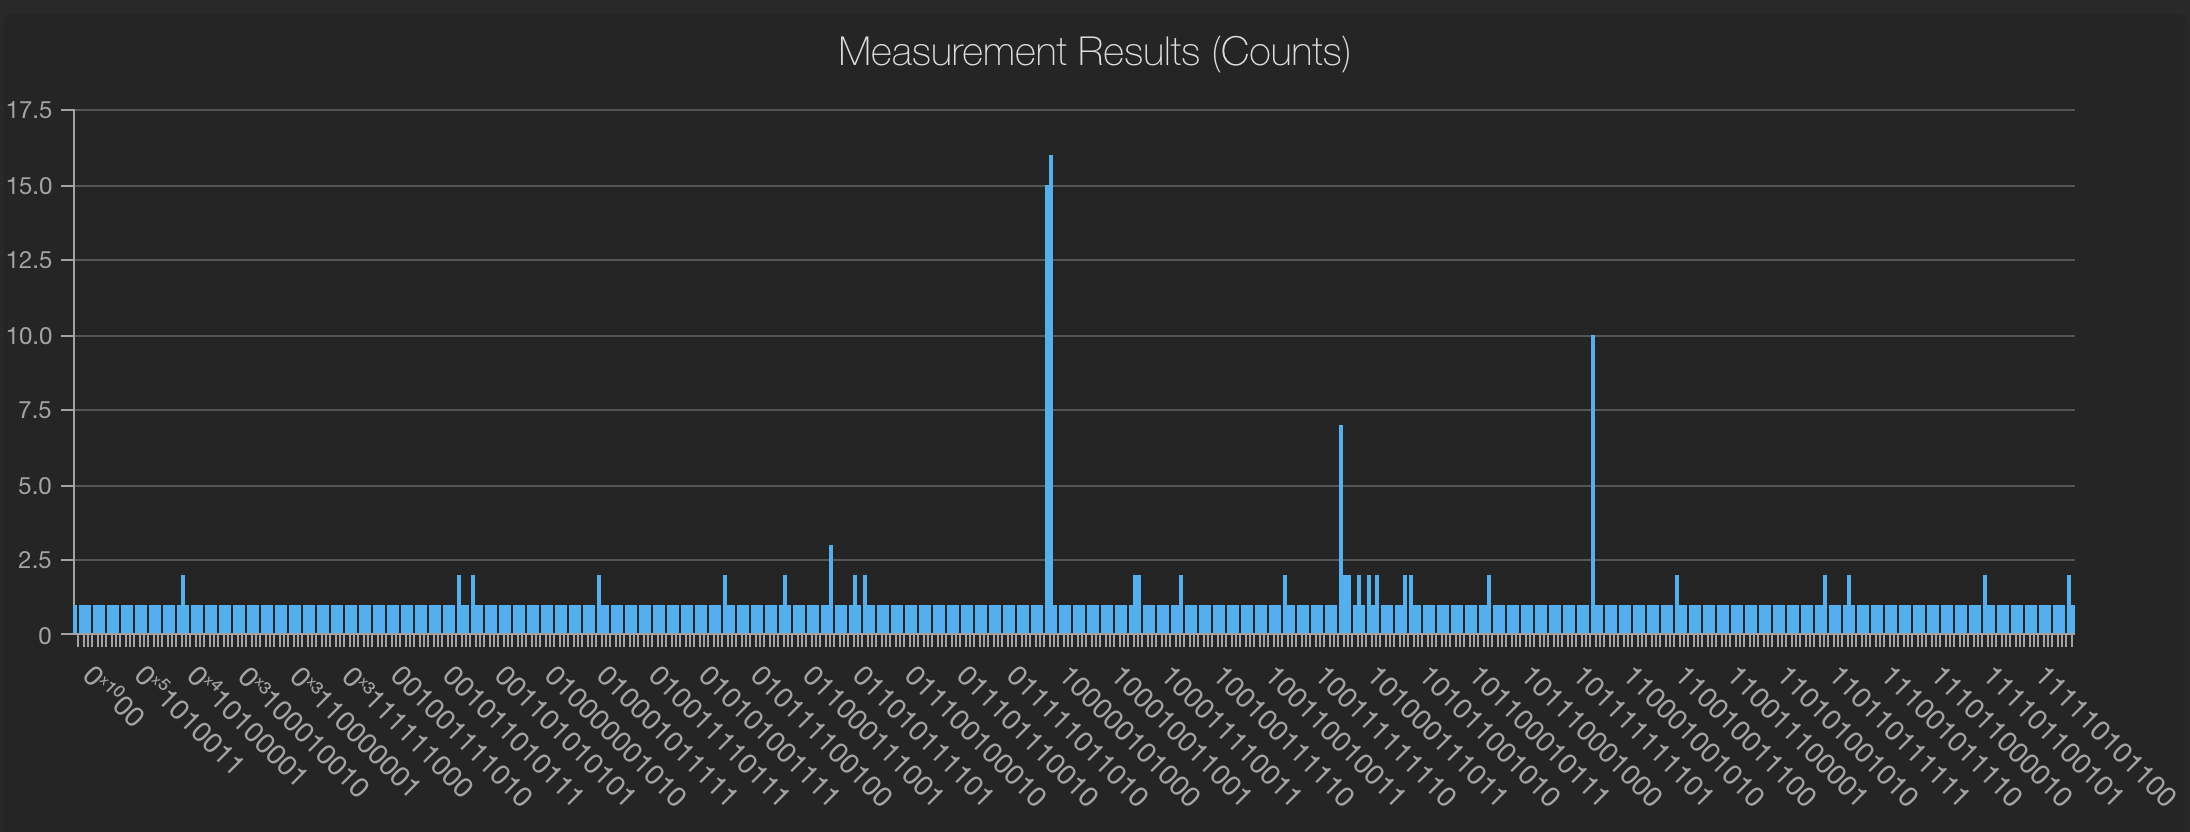

These are the counts of the sampled bit-strings, out of the 500 samples we drew from the circuit. You can see that few of the bit strings were sampled with a much higher probability. Let's Extract `x` and `y` values from the sampling results, to see whether we've got inputs for "c":

In [15]:
samples = []
for x, y, shot in [
    [sample.state["x"], sample.state["y"], sample.shots]
    for sample in result.parsed_counts
]:
    foo_out = foo(x, y)
    samples = samples + [foo_out] * shot
    if foo_out == "c":
        print(f"'c' satisfying sample: {x + y}")

'c' satisfying sample: 6.0
'c' satisfying sample: 6.0
'c' satisfying sample: 2.0
'c' satisfying sample: 6.0


Which exactly corresponds to the 4 peaks in the results.

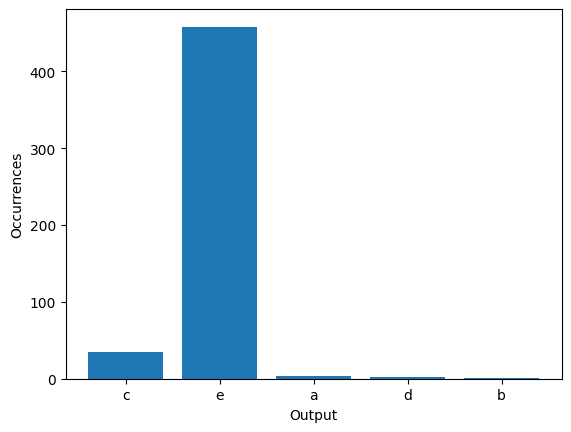

In [16]:
plot_outputs(samples)

And "c" was indeed sampled with higher probability! If we did 36 grover repetitions, we would expect to get c with probability ~1.

## Notes
- While potentially "black-box" fuzzing can also benefit from quantum computers, it requires in general a high amount of quantum resources, in order to emulate the state of the classical program. On the otherhand, the "white-box" case is a lower hangning fruit, where a hybrid quantum-classical approach can be taken, with less resources required.
- Here we showed quadratic improvement in comparison to a classical "brute-force" solver. However in reality there are much faster classical solvers. As a basic example, a solver can "prune" branches of search by backtracking in case a partial assignment is already not satisfiable. Such modifications are in general feasible also on a quantum computer. For example, see [[5](#Backtrack)] on Quantum Backtracking.

# References

<a name='Whitebox'>[1]</a>: [E. Bounimova, P. Godefroid and D. Molnar, "Billions and billions of constraints: Whitebox fuzz testing in production," 2013 35th International Conference on Software Engineering (ICSE), San Francisco, CA, USA, 2013, pp. 122-131, doi: 10.1109/ICSE.2013.6606558.](https://ieeexplore.ieee.org/document/6606558)

<a name='Gro97'>[2]</a>: [Grover, Lov K. "Quantum mechanics helps in searching for a needle in a haystack." Physical review letters 79.2 (1997): 325.](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.79.325)

<a name='GroWiki'>[3]</a>: [Grover's algorithm (Wikipedia)](https://en.wikipedia.org/wiki/Grover%27s_algorithm)

<a name='FPAA'>[4]</a>: [Yoder, Theodore J. et al. “Fixed-point quantum search with an optimal number of queries.” Physical review letters 113 21 (2014): 210501](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.113.210501)

<a name='Backtrack'>[5]</a>: [Montanaro, Ashley. (2015). Quantum walk speedup of backtracking algorithms. Theory of Computing. 14. 10.4086/toc.2018.v014a015](https://theoryofcomputing.org/articles/v014a015/)
